# Reconocimiento facial ;)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
DIR_KNOWNS = 'knowns'
DIR_UNKNOWNS = 'unknowns'
DIR_RESULTS = 'results'

In [3]:
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

In [4]:
print(mobilenet)

In [5]:
# Cargar imagen
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{name}'), cv2.COLOR_BGR2RGB)

In [6]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes

In [12]:
# Dibujar bounding boxes
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

In [13]:
# Extraer rostros
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

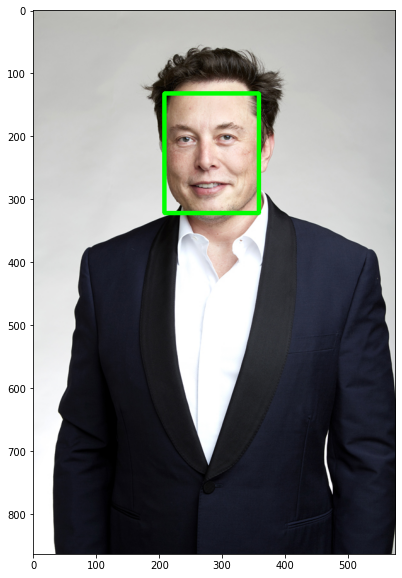

In [14]:
name = 'Elon.jpg'
image = load_image(DIR_UNKNOWNS,name)
bboxes = detect_faces(image)
for box in bboxes:
    detected_faces = draw_box(image,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

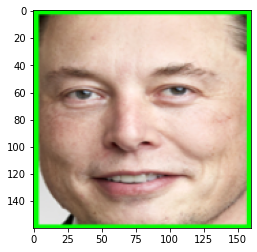

In [15]:
faces = extract_faces(image,bboxes)
plt.imshow(faces[0])

In [16]:
# FaceNet
facenet = load_model('facenet_keras.h5')
print(facenet.input_shape)
print(facenet.output_shape)

(None, 160, 160, 3)
(None, 128)


In [17]:
def compute_embedding(model,face):
    face = face.astype('float32')
    
    mean, std = face.mean(), face.std()
    face = (face-mean) / std
    
    face = np.expand_dims(face,axis=0)
    
    embedding = model.predict(face)
    return embedding

In [18]:
embedding = compute_embedding(facenet,faces[0])
print(embedding)

[[ 0.518734    1.405025   -0.51752937  0.25018245  0.37123588  1.0180957
   0.40367162 -0.20578818  0.8249822  -1.0280724   1.8572507  -0.27353728
  -1.2777355   0.33348757 -1.1964724  -0.8851815  -2.033825   -1.7288084
  -1.0516655   0.6066213   0.13680302  0.6192904  -0.20390478 -0.3821777
   2.027954   -0.8704886   0.06494886 -2.4212632   0.01466789 -1.0554898
   0.8198693  -1.15982     0.02879848  0.18201706 -1.3629192   0.25517875
  -0.04557372  0.51108575  0.9762454  -0.88908374  0.288194    0.52515006
  -1.5416813   0.17802691 -1.2317488  -0.26876783 -0.83529514  1.1819654
  -0.0684334   0.58379483 -0.11206971  1.8215684   1.4193512  -0.9161564
   0.52172625 -0.26714444  1.2459902  -1.0519838   0.08531131  0.61277163
   1.1226677  -0.08265175 -0.2975625  -0.76741475  1.1455191  -0.06219779
  -1.0686789   0.25993526 -2.2997627   0.16954918 -0.72784114 -0.718217
  -2.621463   -1.2705718   0.14885053  0.10298098 -0.11318189  1.8808618
  -0.39930153  0.81521094  0.08615319 -0.017399

In [19]:
# Embeddings referencia
known_embeddings = []

print('Procesando rostros conocidos...')
for name in os.listdir(DIR_KNOWNS):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image(DIR_KNOWNS,name)
        bboxes = detect_faces(image)
        face = extract_faces(image,bboxes)
        known_embeddings.append(compute_embedding(facenet,face[0]))       
        
        
        

Procesando rostros conocidos...
   elon-musk-public-transit-dezeen-2364-sq.jpg
   Elon_Musk_Royal_Society.jpg


In [20]:
print(known_embeddings)

[array([[-4.01776433e-02,  7.27535486e-01,  1.08666100e-01,
         5.15575528e-01,  4.84894663e-01,  9.38179970e-01,
         9.81507540e-01,  1.38167366e-01,  3.87172043e-01,
        -1.63231671e+00,  1.82452631e+00, -8.57975721e-01,
        -6.71785951e-01,  5.24990678e-01, -7.57274747e-01,
        -1.44197643e-01, -1.92460585e+00, -2.14390945e+00,
        -1.64922750e+00,  1.01364815e+00,  4.58916217e-01,
         5.99299848e-01, -6.40047342e-02, -1.53266251e+00,
         1.14006984e+00, -7.88827240e-01,  4.50406492e-01,
        -1.85431182e+00, -9.11103904e-01, -5.95635176e-01,
         6.31222248e-01, -1.23491228e+00, -3.98041576e-01,
         1.82482541e-01, -1.35087299e+00,  8.93299222e-01,
        -3.80305976e-01, -4.08414304e-01,  1.30375648e+00,
        -9.05499578e-01,  4.27820772e-01, -2.28327885e-01,
        -1.85146725e+00, -4.67584133e-01, -9.70129669e-01,
        -3.83548498e-01, -2.66142577e-01,  3.95122230e-01,
        -5.19954622e-01,  3.06513846e-01, -7.39681602e-

In [22]:
def compare_faces(embs_ref, emb_desc, umbral=11):
    distancias = []
    for emb_ref in embs_ref:
        distancias.append(np.linalg.norm(emb_ref-emb_desc))
    distancias = np.array(distancias)
    return distancias, list(distancias<=umbral)

In [23]:
# Reconocimiento (????) de rostros desconocidos
print('Procesando imágenes desconocidas...')
for name in os.listdir(DIR_UNKNOWNS):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image(DIR_UNKNOWNS,name)
        bboxes = detect_faces(image)
        faces = extract_faces(image,bboxes)
        
        # Por cada rostro calcular embedding
        img_with_boxes = image.copy()
        for face, box in zip(faces,bboxes):
            emb = compute_embedding(facenet,face)
            
            _, reconocimiento = compare_faces(known_embeddings,emb)
            
            if any(reconocimiento):
                print('     match!')
                img_with_boxes = draw_box(img_with_boxes,box,(0,255,0))
            else:
                img_with_boxes = draw_box(img_with_boxes,box,(255,0,0))
            
        cv2.imwrite(f'{DIR_RESULTS}/{name}',cv2.cvtColor(img_with_boxes,cv2.COLOR_RGB2BGR))
print('¡Término la búsqueda!')                  
            
        
        
        

Procesando imágenes desconocidas...
   adam-sandler-celebrity-wallpaper-66922-69214-hd-wallpapers-1024x682.jpg
   intro-1586436827.jpg
   leonardo-dicaprio-una-estrella-con-padre-hippie-que-huyo-de-la-fama-facil.jpg
   BwioAwkz_400x400.jpg
   1561646690_672765_1561731914_noticia_normal.jpg
   1564575562023.jpg
   elon-musk-mascarilla-getty.jpg
     match!
   1206292068.jpg.jpg
     match!
   MARGOT-ROBBIE.jpg
   BPOY.01.Elon-Musk.jpg
     match!
   Elon.jpg
     match!
   1600183074_763698_1600274818_noticia_normal.jpg
     match!
   1588836648_754103_1588836866_noticia_normal_recorte1.jpg
     match!
¡Término la búsqueda!
